# Imbalanced Testing

In [1]:
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout, GRU, Conv1D, Flatten, Reshape

import os
import numpy as np
import sys
import tensorflow as tf
import random
import keras

SEED = 42

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    keras.utils.set_random_seed(seed)

def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

# Call the above function with seed value
set_global_determinism(seed=SEED)

In [2]:
os.chdir("../")
folder_path = os.path.abspath("functions/") #INPUT_PATH)#'path_to_your_folder')  # Replace with the actual folder path
sys.path.insert(0, folder_path)

from Predictions import (
    PredictionExperiment,
    PredictionModel,
    get_info_experiment
)

c:\Users\marti\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
# Re-import necessary libraries after kernel reset
import numpy as np
from scipy.interpolate import PchipInterpolator
from statsmodels.stats.stattools import medcouple

def compute_tukey_boxplot_bounds(y):
    """
    Compute boxplot bounds using Tukey's original rule (no skewness correction).
    """
    q1 = np.percentile(y, 25)
    q3 = np.percentile(y, 75)
    iqr = q3 - q1

    lower = q1 + 0.1*iqr
    upper = q3 
    median = np.median(y)

    return lower, median, upper

def compute_adjusted_boxplot_bounds(y):
    """
    Compute adjusted boxplot bounds using medcouple (MC) for skewness adjustment.
    """
    q1 = np.percentile(y, 25)
    q3 = np.percentile(y, 75)
    iqr = q3 - q1
    mc = medcouple(y)

    if mc >= 0:
        lower = q1 - 1.5 * np.exp(-4 * mc) * iqr
        upper = q3 + 1.5 * np.exp(3 * mc) * iqr
    else:
        lower = q1 - 1.5 * np.exp(-3 * mc) * iqr
        upper = q3 + 1.5 * np.exp(4 * mc) * iqr

    median = np.median(y)
    return lower, median, upper

def create_relevance_function_tukey(y):
    """
    Create a PCHIP-based relevance function φ(y) using Tukey boxplot bounds.
    """
    lower, median, upper = compute_adjusted_boxplot_bounds(y)
    
    # Extend with actual min/max to smooth edges
    x = np.array([min(y), lower, median, upper, max(y)])
    relevance = np.array([0, 0, 0.5, 1.0, 1.0])

    # Ensure strictly increasing x by removing duplicate values
    x_unique, idx = np.unique(x, return_index=True)
    relevance_unique = relevance[idx]
    print(x_unique)
    print(relevance_unique)
    pchip = PchipInterpolator(x_unique, relevance_unique, extrapolate=True)
    return pchip

def compute_sera(y_true, y_pred, relevance_fn, step=0.01):
    """
    Compute SERA metric given true values, predictions, and a relevance function φ(y).
    """
    t_values = np.arange(0, 1 + step, step)
    ser_t = []

    for t in t_values:
        indices = [i for i, y in enumerate(y_true) if relevance_fn(y) >= t]
        if len(indices) == 0:
            ser_t.append(0.0)
            continue
        squared_errors = [(y_pred[i] - y_true[i]) ** 2 for i in indices]
        ser_t.append(np.mean(squared_errors))

    sera_score = np.trapz(ser_t, t_values)
    return sera_score, t_values, ser_t



In [4]:
region = "chile"
indices = ["HWN", "HWD", "HWF", "HWM", "HWA"]

hws = pd.read_csv(f"data/local_data/monthly/HWs_chile_central.csv")


In [5]:
scaler = StandardScaler()
hws[indices] = scaler.fit_transform(hws[indices])

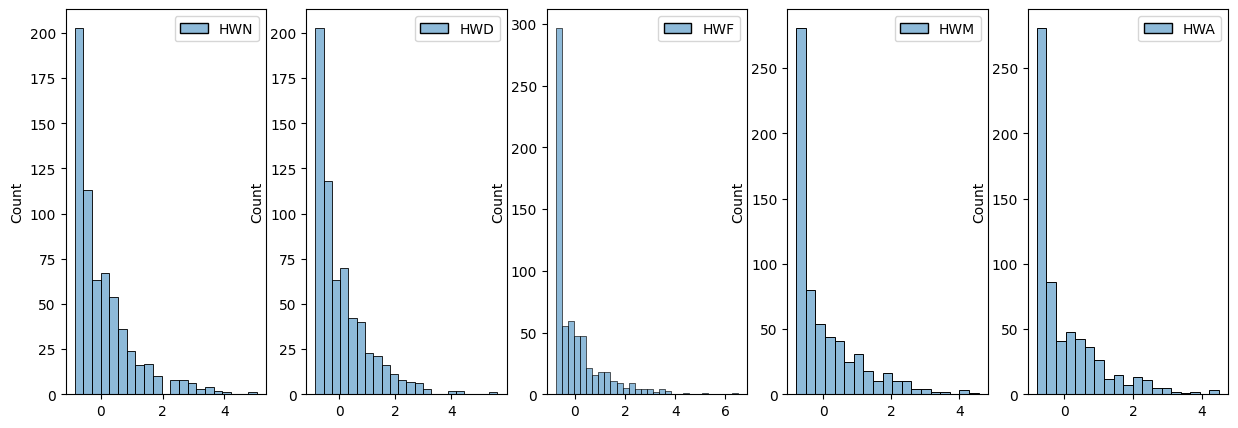

In [6]:
indices = ["HWN", "HWD", "HWF", "HWM", "HWA"]
fig, axs = plt.subplots(1, 5, figsize=(15,5))
for i, index in enumerate(indices):
    sns.histplot(hws[[index]], ax=axs[i])


In [7]:
hws_index = hws[["HWF"]].to_numpy()
hws_index = hws_index.reshape(hws_index.shape[0])

In [8]:
compute_adjusted_boxplot_bounds(hws_index)

(-1.1692892810242344, -0.30647585455315646, 4.561547586528888)

In [9]:
relevance = create_relevance_function_tukey(hws_index)

[-1.16928928 -0.75525247 -0.30647585  4.56154759  6.49996949]
[0.  0.  0.5 1.  1. ]


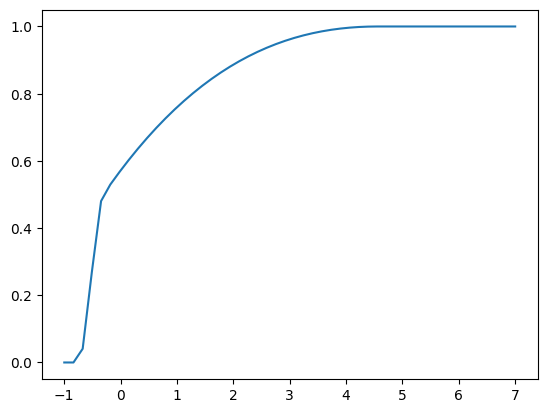

In [10]:
x = np.linspace(-1, 7)
plt.plot(x, relevance(x))

1/1 [==============================] - 0s 23ms/step


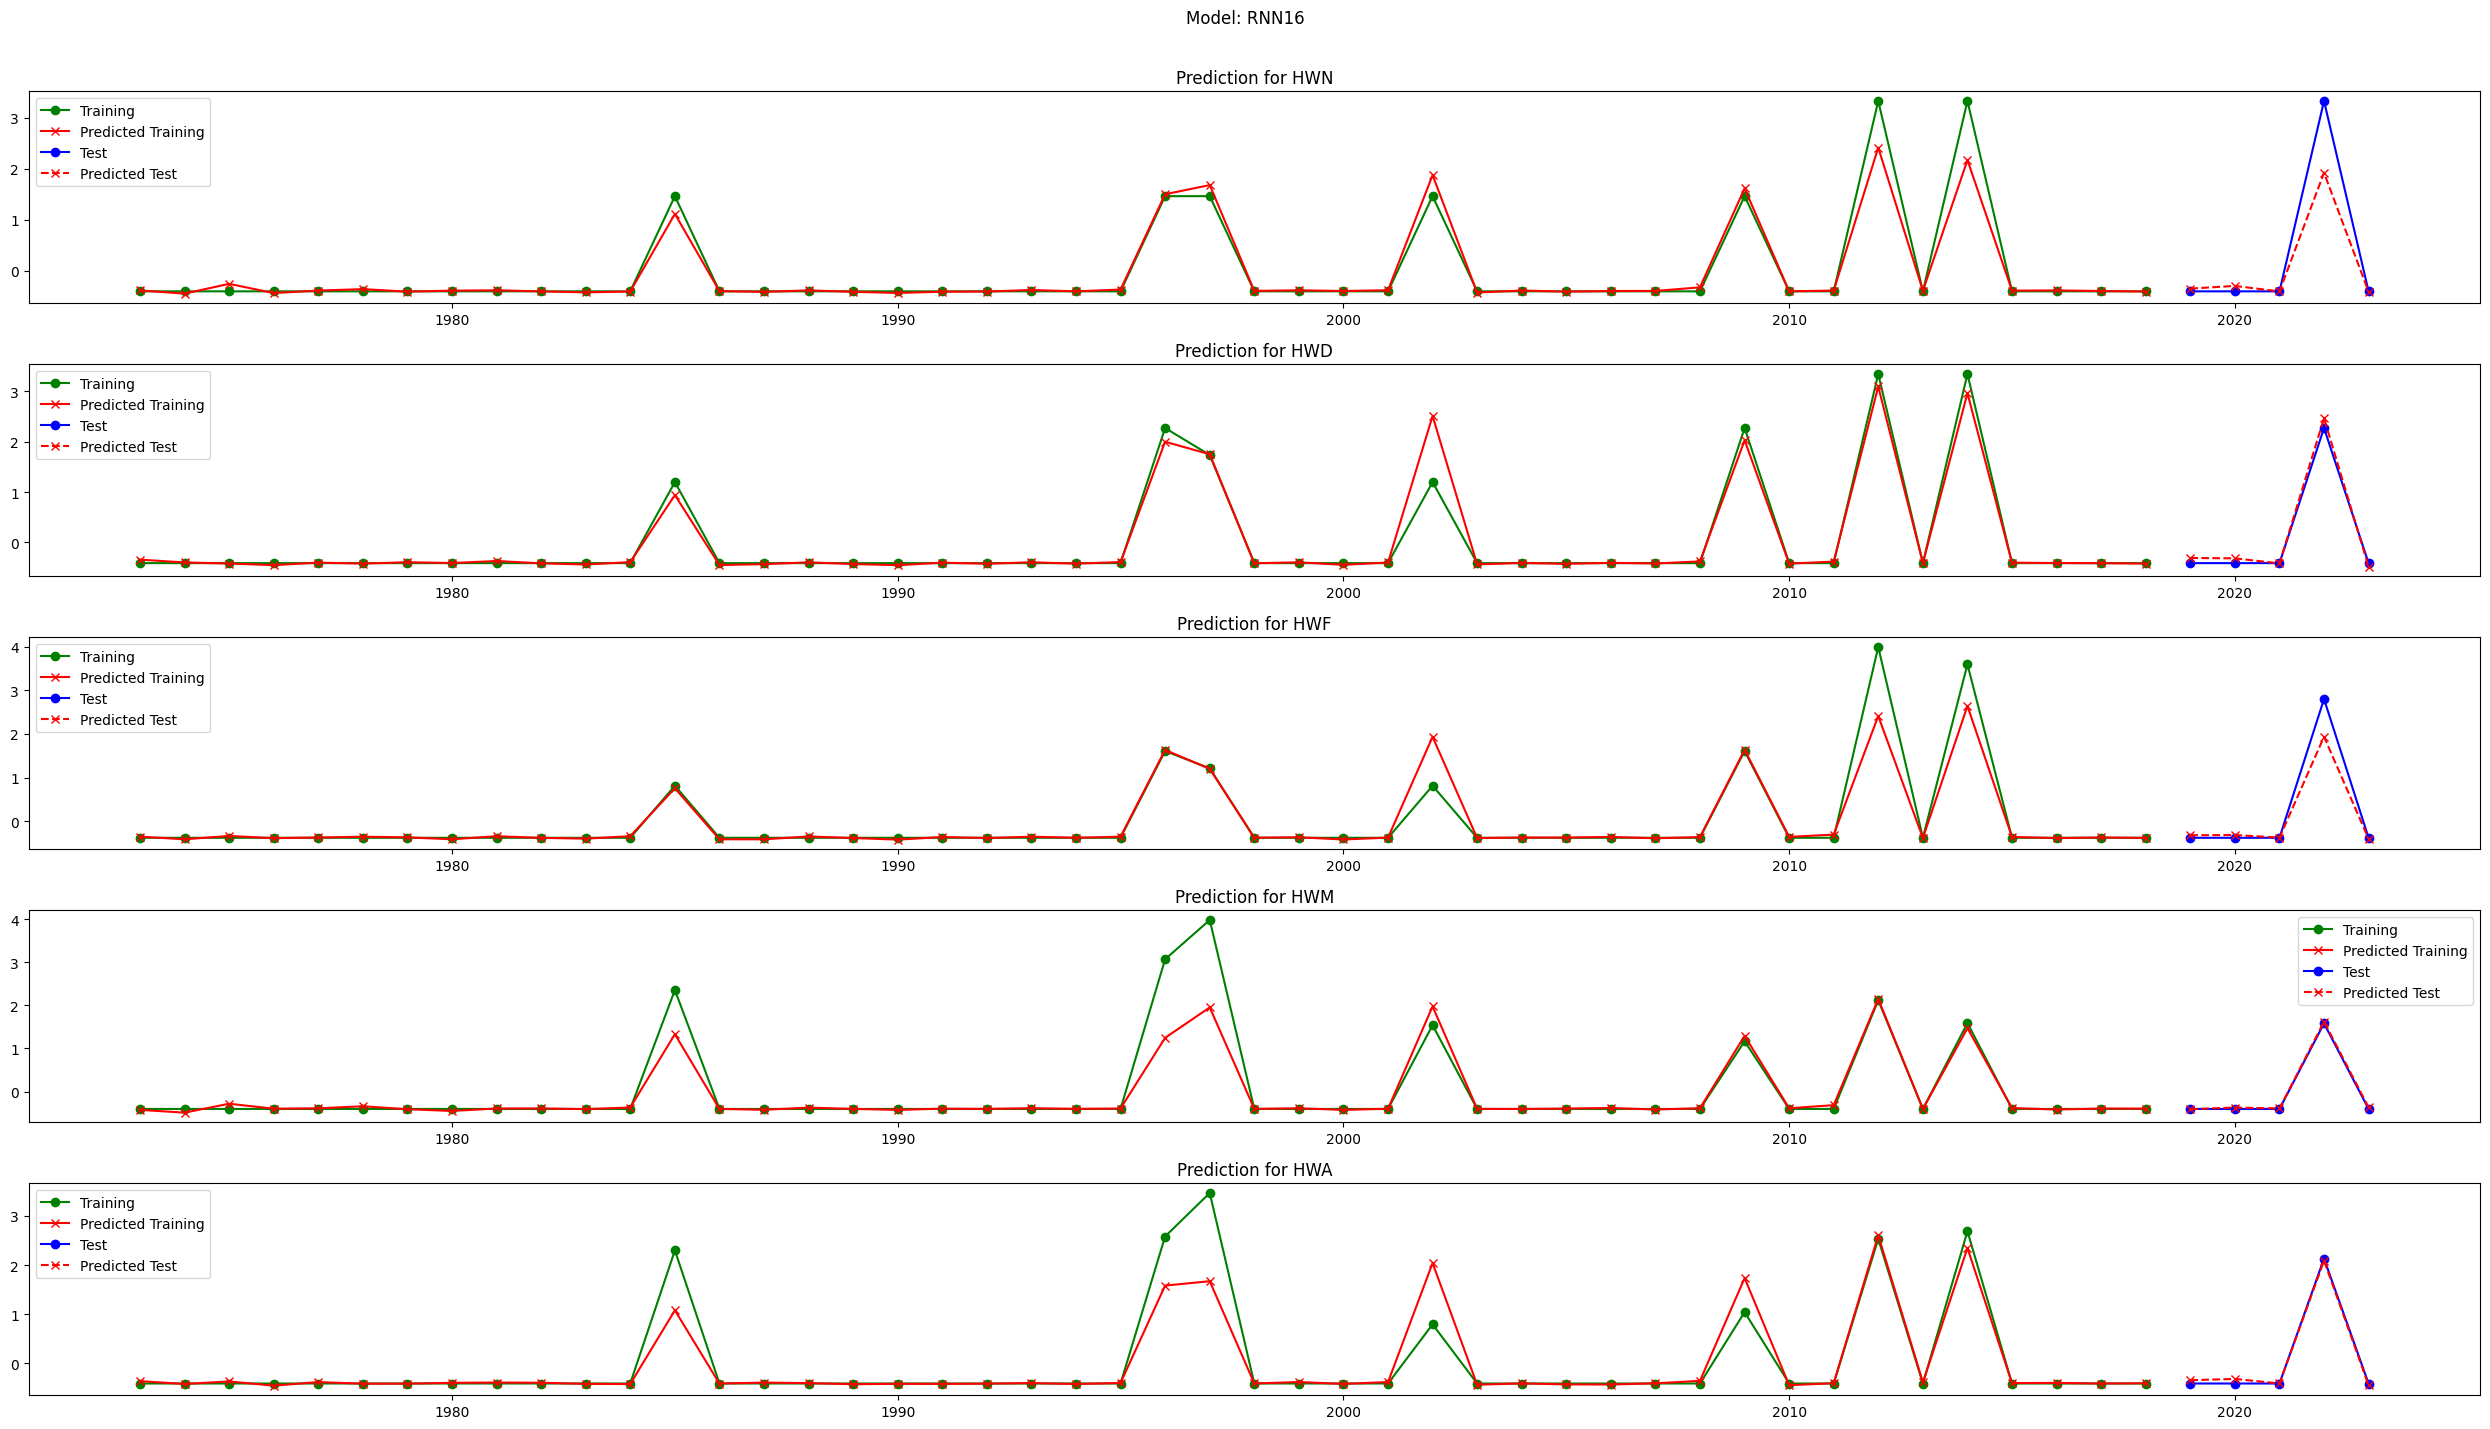

In [11]:
id = "231a6330"
season = 12
data = pd.read_parquet(f"data/locally_features/{region}/predictor_{id}_{season}.parquet")

model = Sequential([
    SimpleRNN(16, activation="tanh", input_shape=(1, len(data.columns) - len(indices))),
    Dropout(0.1),  # Regularization
    Dense(8, activation="relu"),
    Dense(len(indices))  # Predict 5 indices
    ])

pred = PredictionModel(data, season, indices, model, name_regressor="RNN16")
pred.compile_keras_model()
y_train, y_pred_train = pred.train(5)
y_test, y_pred = pred.predict(5)
dates = pd.date_range(pd.to_datetime(f"1972-{season}"),periods=len(y_train) + len(y_test),freq=pd.offsets.YearBegin(1))
pred.plot_predictions(dates, 5, y_train, y_pred_train, y_test, y_pred)

In [12]:
y_pred

array([[-0.34920317, -0.30756456, -0.3247298 , -0.409616  , -0.34052503],
       [-0.29645085, -0.31522882, -0.31833348, -0.371401  , -0.31482673],
       [-0.4035993 , -0.41549143, -0.37832856, -0.39368832, -0.4073551 ],
       [ 1.9239168 ,  2.4664469 ,  1.9362983 ,  1.6200578 ,  2.0905395 ],
       [-0.41180664, -0.48011678, -0.4040696 , -0.36565277, -0.44248965]],
      dtype=float32)

In [13]:
sera_score, t_s, ser_t = compute_sera(y_test[["HWF"]].to_numpy(), y_pred[:,2], relevance)

In [14]:
print("Prediction SERA", sera_score)

Prediction SERA 0.44939295495024256


In [15]:
sera_score, t_s, ser_t = compute_sera(y_train[["HWF"]].to_numpy(), y_pred_train[:,2], relevance)
print("Training SERA", sera_score)

Training SERA 0.5887858727928373


1/1 [==============================] - 0s 38ms/step


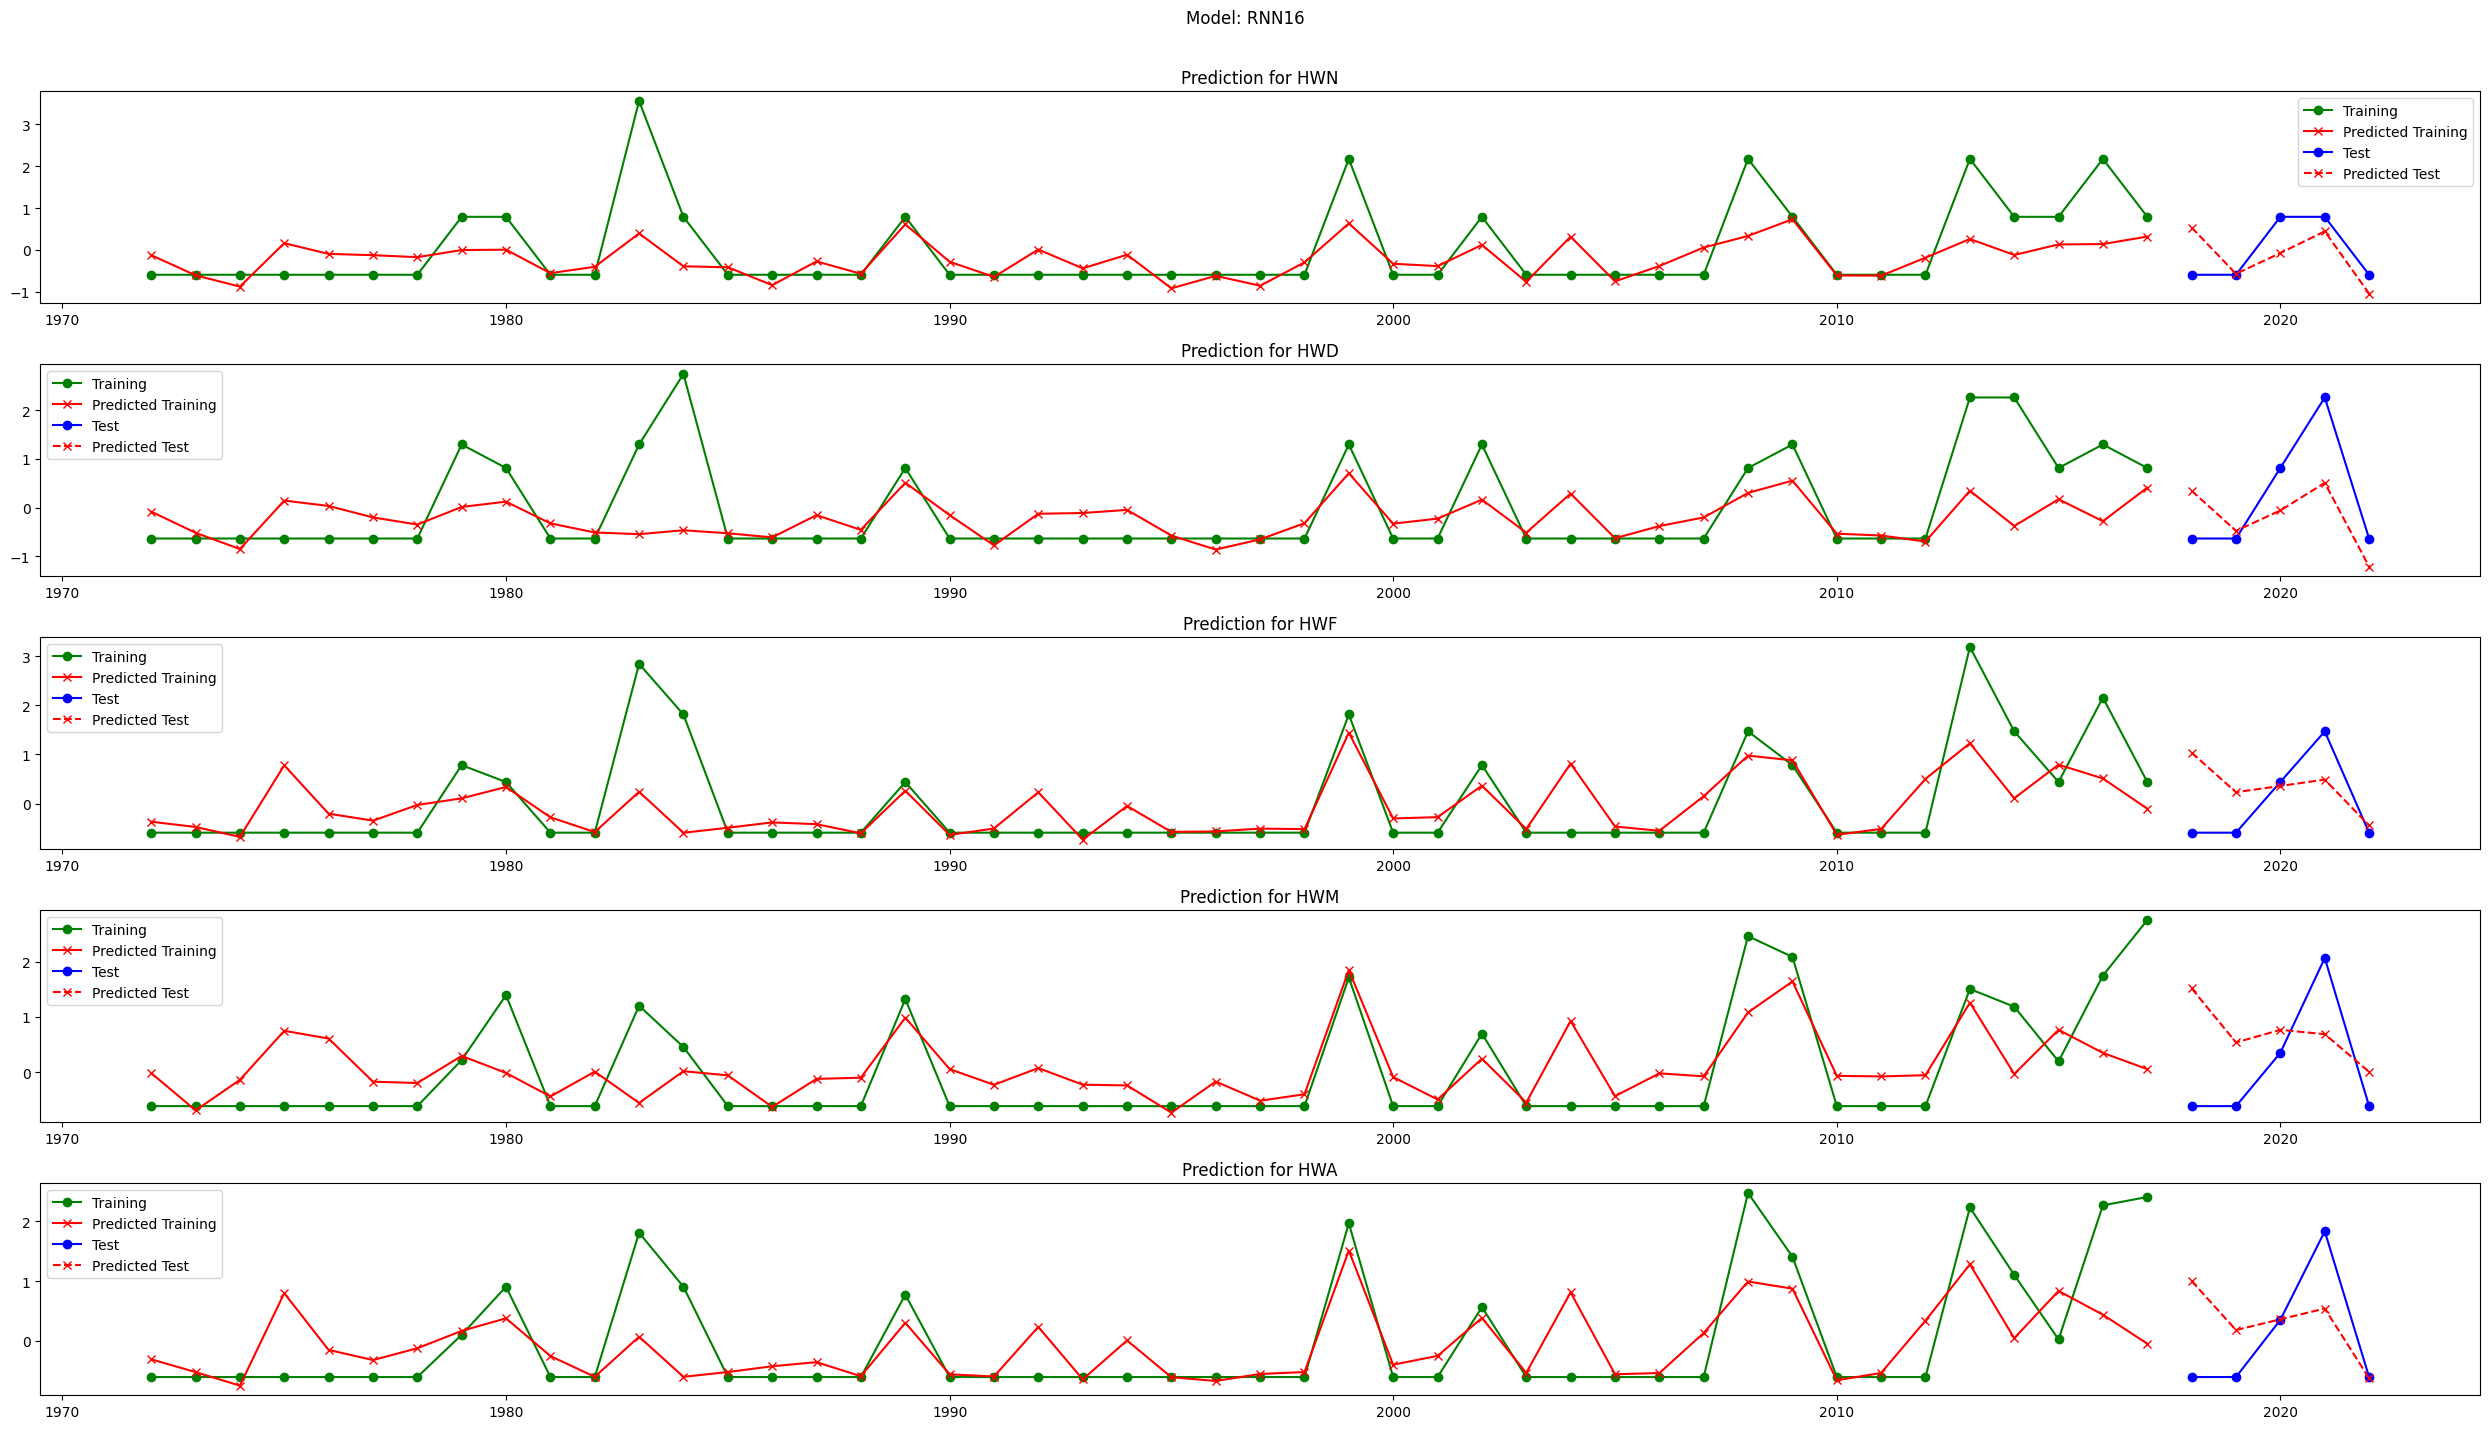

In [16]:
id = "231a6330"
season = 1
data = pd.read_parquet(f"data/locally_features/{region}/predictor_{id}_{season}.parquet")

model = Sequential([
    SimpleRNN(16, activation="tanh", input_shape=(1, len(data.columns) - len(indices))),
    Dropout(0.1),  # Regularization
    Dense(8, activation="relu"),
    Dense(len(indices))  # Predict 5 indices
    ])

pred = PredictionModel(data, season, indices, model, name_regressor="RNN16")
pred.compile_keras_model()
y_train, y_pred_train = pred.train(5)
y_test, y_pred = pred.predict(5)
dates = pd.date_range(pd.to_datetime(f"1972-{season}"),periods=len(y_train) + len(y_test),freq=pd.offsets.YearBegin(1))
pred.plot_predictions(dates, 5, y_train, y_pred_train, y_test, y_pred)

In [17]:
sera_score, t_s, ser_t = compute_sera(y_test[["HWF"]].to_numpy(), y_pred[:,2], relevance)

In [18]:
print("Prediction SERA", sera_score)

Prediction SERA 0.5311192266883753


In [19]:
sera_score, t_s, ser_t = compute_sera(y_train[["HWF"]].to_numpy(), y_pred_train[:,2], relevance)
print("Training SERA", sera_score)

Training SERA 2.038517133083731


1/1 [==============================] - 0s 30ms/step


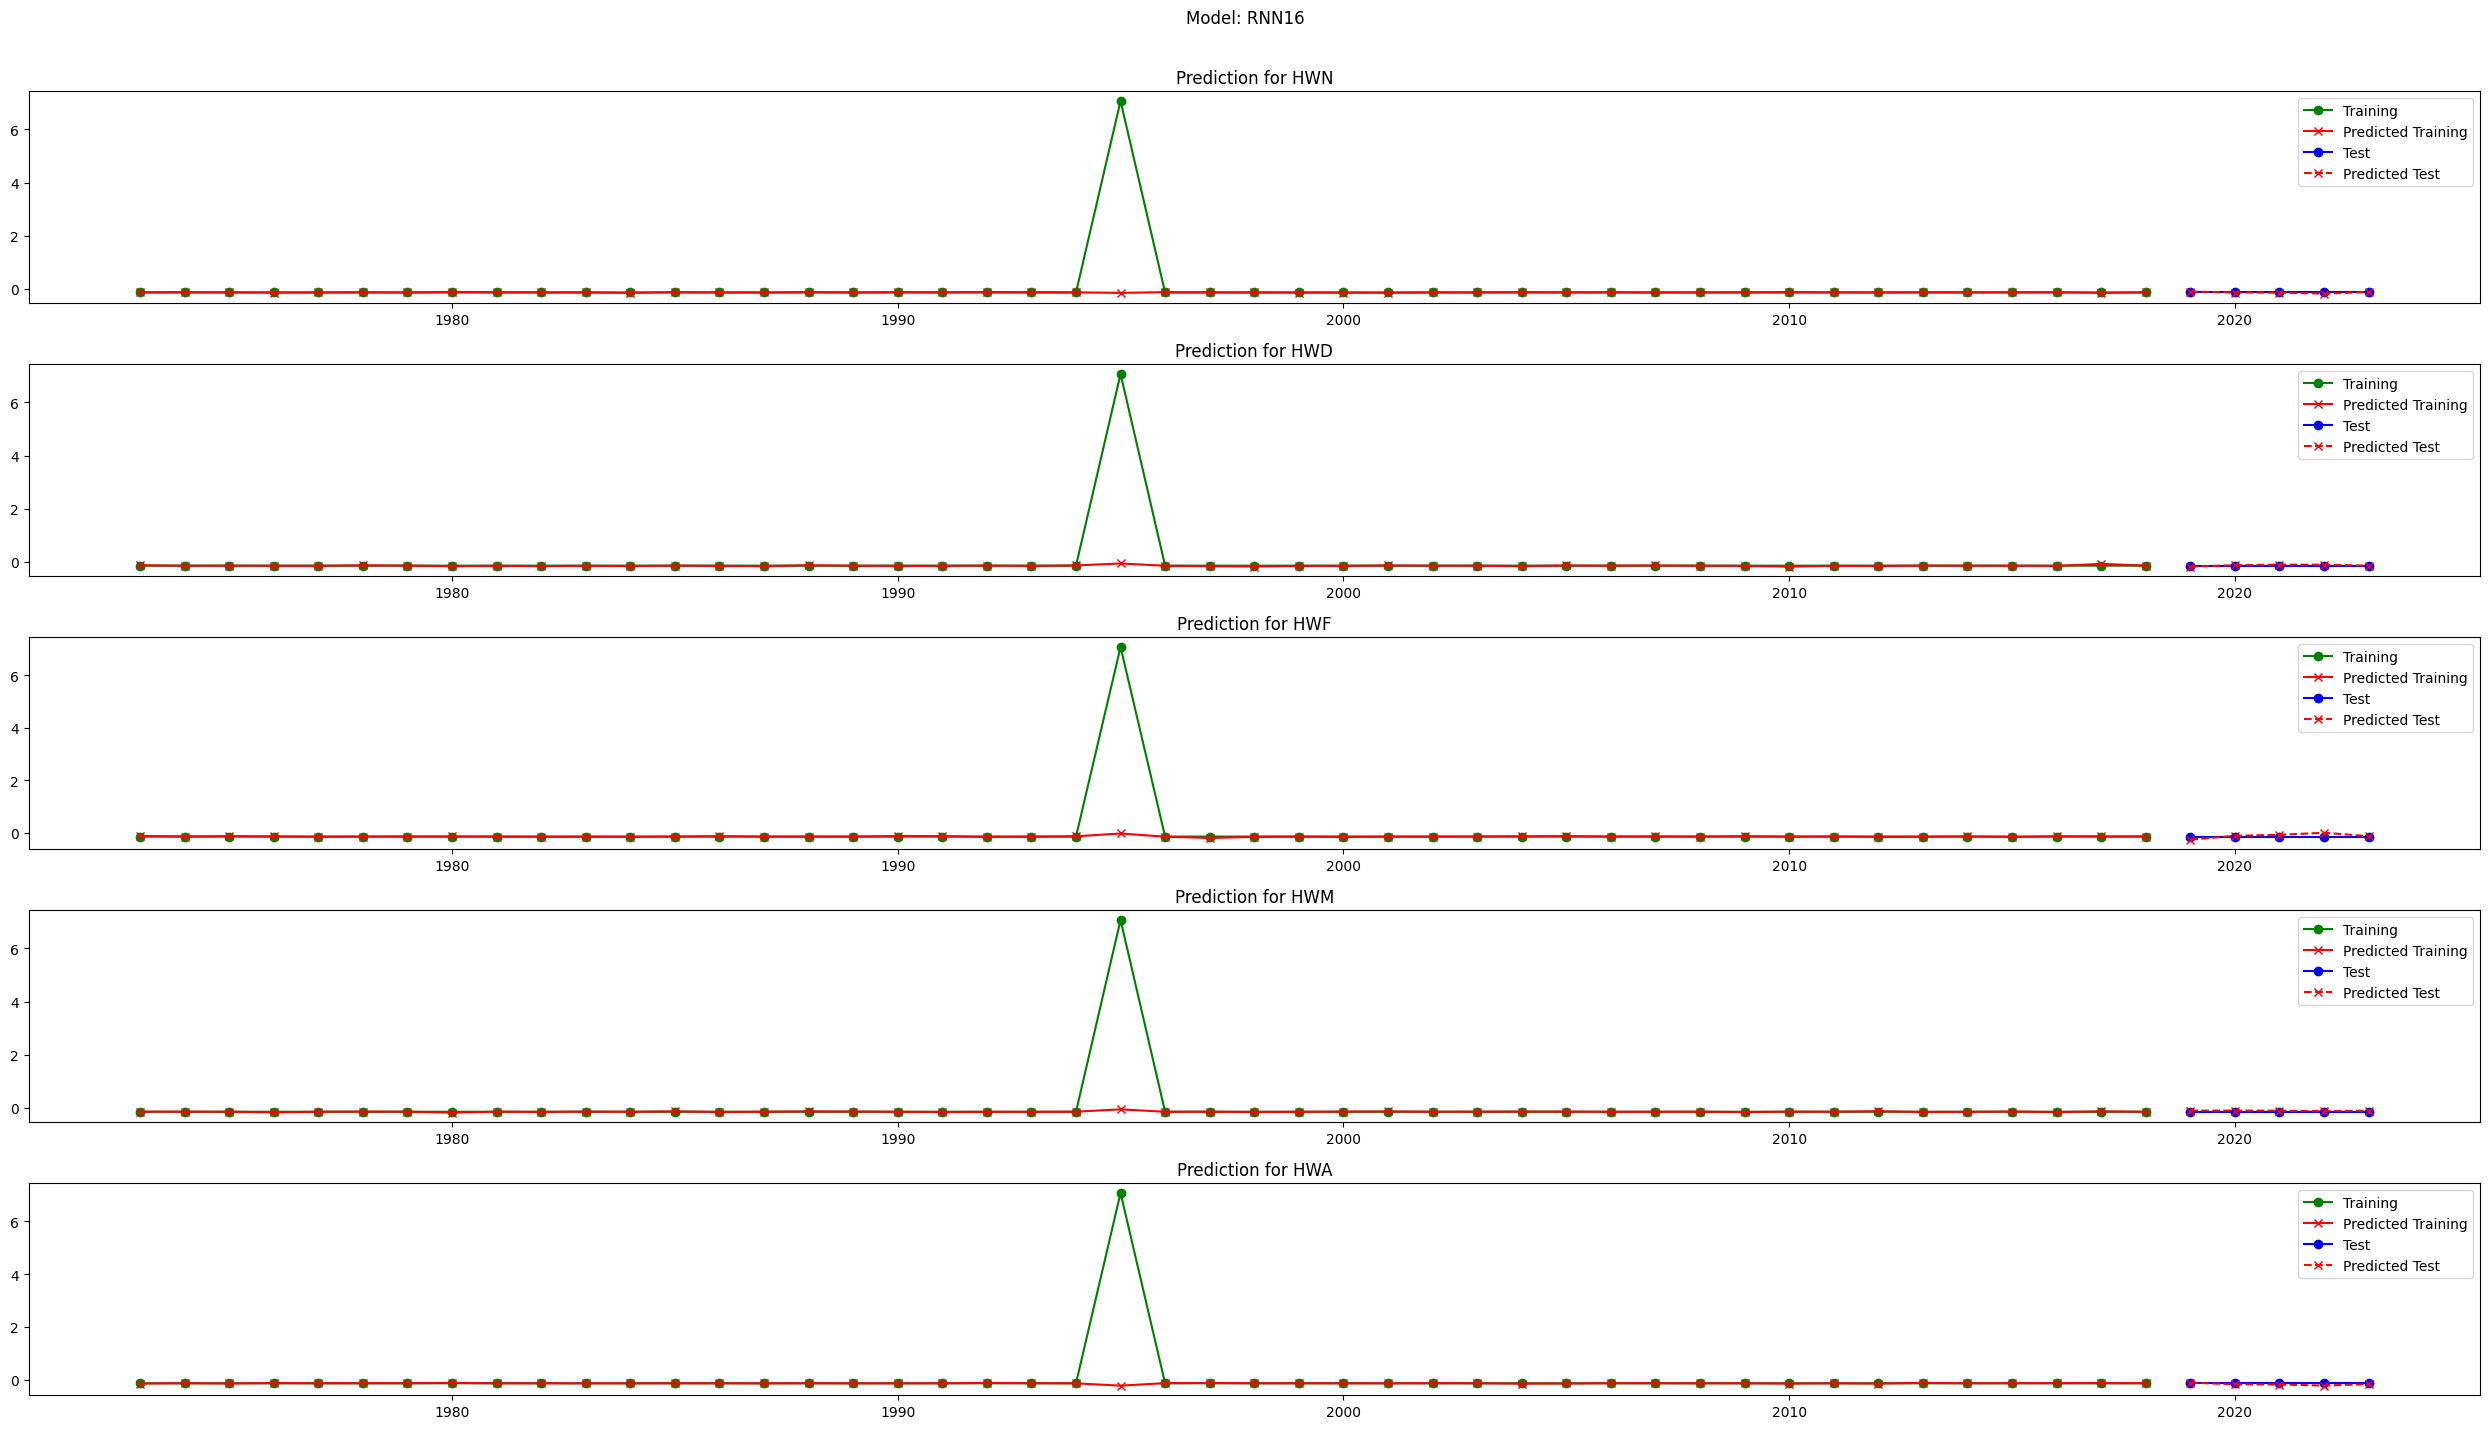

In [20]:
id = "e0ec7330"
season = 6
data = pd.read_parquet(f"data/locally_features/{region}/predictor_{id}_{season}.parquet")

model = Sequential([
        Conv1D(16, kernel_size=1, activation="relu", input_shape=(1, len(data.columns) - len(indices))),
        Reshape((1, 16)),  # Back to time dimension
        SimpleRNN(8, activation="tanh"),
        Dropout(0.1),
        Dense(len(indices))
    ])
pred = PredictionModel(data, season, indices, model, name_regressor="RNN16")
pred.compile_keras_model()
y_train, y_pred_train = pred.train(5)
y_test, y_pred = pred.predict(5)
dates = pd.date_range(pd.to_datetime(f"1972-{season}"),periods=len(y_train) + len(y_test),freq=pd.offsets.YearBegin(1))
pred.plot_predictions(dates, 5, y_train, y_pred_train, y_test, y_pred)

In [21]:
sera_score, t_s, ser_t = compute_sera(y_test[["HWF"]].to_numpy(), y_pred[:,2], relevance)

In [22]:
print("Prediction SERA", sera_score)

Prediction SERA 0.0043314768917810335


In [23]:
sera_score, t_s, ser_t = compute_sera(y_train[["HWF"]].to_numpy(), y_pred_train[:,2], relevance)
print("Training SERA", sera_score)

Training SERA 23.995135600532016
